## 1. Setup

In [73]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

In [74]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda


In [75]:
data_dir = os.path.join("/kaggle", "input", "cityscapes-image-pairs", "cityscapes_data")
train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

# Get a list of all image file paths in train_dir
train_image_paths = [os.path.join(train_dir, filename) for filename in os.listdir(train_dir) if filename.endswith(".jpg")]

# Get a list of all image file paths in val_dir
val_image_paths = [os.path.join(val_dir, filename) for filename in os.listdir(val_dir) if filename.endswith(".jpg")]

# Combine the lists of image file paths
all_image_paths = train_image_paths + val_image_paths
print(len(all_image_paths))


# Splitting into training and temporary combined set
train_image_paths, temp_image_paths = train_test_split(all_image_paths, test_size=0.3, random_state=42)

# Splitting the temporary combined set into validation and test sets
val_image_paths, test_image_paths = train_test_split(temp_image_paths, test_size=1/3, random_state=42)

print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of validation images: {len(val_image_paths)}")
print(f"Number of test images: {len(test_image_paths)}")

2975 500
3475
Number of training images: 2432
Number of validation images: 695
Number of test images: 348


## 2. Analyze data

/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/1269.jpg


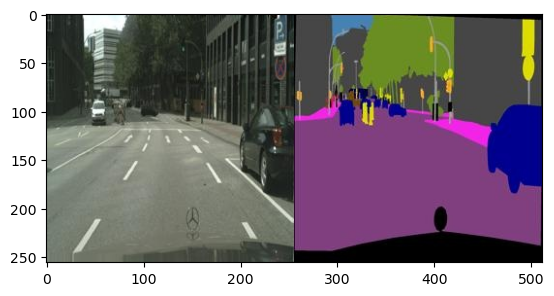

In [76]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

In [77]:
def split_image(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

(256, 512, 3)
0 255 0 255


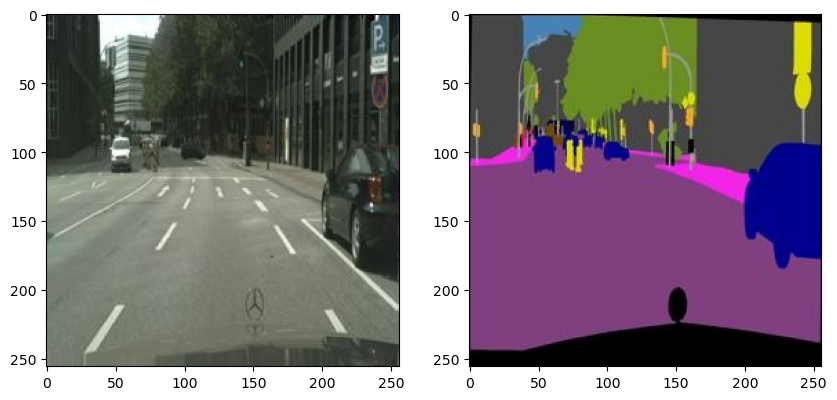

In [78]:
sample_image = np.array(sample_image)
print(sample_image.shape)
cityscape, label = split_image(sample_image)
print(cityscape.min(), cityscape.max(), label.min(), label.max())
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

## 3. Define Labels

In [79]:
"""
color_set = set()
for train_fn in tqdm(train_fns[:10]):
    train_fp = os.path.join(train_dir, train_fn)
    image = np.array(Image.open(train_fp))
    cityscape, label = split_image(sample_image)
    label = label.reshape(-1, 3)
    local_color_set = set([tuple(c) for c in list(label)])
    color_set.update(local_color_set)
color_array = np.array(list(color_set))
"""

num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:10, :])

(1000, 3)
[[ 75  27 238]
 [213  96 213]
 [175 176  76]
 [126 193 210]
 [175  67 210]
 [129  32  59]
 [180 232 192]
 [ 42 181  68]
 [167 194  30]
 [ 70 239 126]]


In [80]:
num_classes = 10
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10)

In [81]:
label_model.predict(color_array[:5, :])

array([8, 3, 7, 4, 3], dtype=int32)

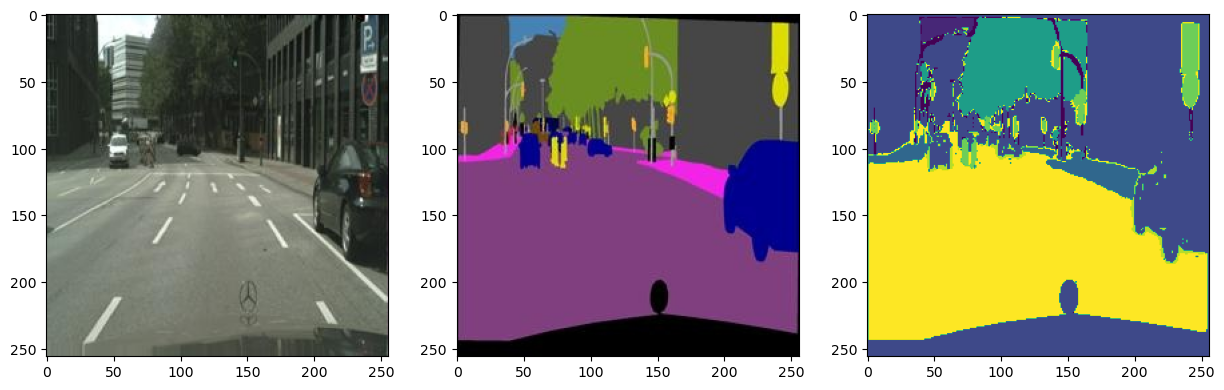

In [82]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [83]:
label_class

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int32)

## 4. Define Dataset

In [86]:
class CityscapeDataset(Dataset):
    
    def __init__(self, image_paths, label_model):
        self.image_paths = image_paths
        self.label_model = label_model
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        image = np.array(image)
        cityscape, label = self.split_image(image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class
    
    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [87]:
dataset = CityscapeDataset(train_image_paths, label_model)
print(len(dataset))

2432


In [88]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


## 5. Define Model

In [89]:
import torch.nn as nn

class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_blocks = nn.ModuleList([
            self.conv_block(in_channels=3, out_channels=64),
            self.conv_block(in_channels=64, out_channels=128),
            self.conv_block(in_channels=128, out_channels=256),
            self.conv_block(in_channels=256, out_channels=512)
        ])
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_blocks = nn.ModuleList([
            self.conv_block(in_channels=1024, out_channels=512),
            self.conv_block(in_channels=512, out_channels=256),
            self.conv_block(in_channels=256, out_channels=128),
            self.conv_block(in_channels=128, out_channels=64)
        ])
        self.expansive_layers = nn.ModuleList([
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        ])
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels)
        )
    
    def forward(self, X):
        contracting_outs = []
        for block in self.contracting_blocks:
            X = block(X)
            contracting_outs.append(X)
            X = nn.MaxPool2d(kernel_size=2, stride=2)(X)
            
        X = self.middle(X)
        
        for i, (expansive_layer, block) in enumerate(zip(self.expansive_layers, self.expansive_blocks)):
            X = expansive_layer(X)
            X = torch.cat((X, contracting_outs[-(i+1)]), dim=1)
            X = block(X)
            
        output = self.output(X)
        return output


In [90]:
class Up_Sample_Conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(Up_Sample_Conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2), # Nearest neighbour for upsampling are two 
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

    
class Repeat(nn.Module):
    def __init__(self, ch_out):
        super(Repeat, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)) 
#Inplace has been set to TRUE so that it modifies the input directly, without allocating any additional output.

    def forward(self, x):
        for i in range(2):
            if i == 0:
                x_rec = self.conv(x)
            x_rec = self.conv(x + x_rec)
        return x_rec

class RR_Conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(RR_Conv, self).__init__()
        self.Repeat_block = nn.Sequential(Repeat(ch_out),Repeat(ch_out))
        self.Conv = nn.Conv2d(ch_in, ch_out, 1, 1, 0)

    def forward(self, input_img):
        input_img = self.Conv(input_img)
        conv_input_img = self.Repeat_block(input_img)
        return input_img + conv_input_img 
    
############
############

class R2UNet(nn.Module):
    def __init__(self, img_ch=3, output_ch=10):
        super(R2UNet, self).__init__()
        
        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.channel_1 = 64 # R2U-net activation maps in first layer
        self.channel_2 = 2*self.channel_1
        self.channel_3 = 2*self.channel_2
        self.channel_4 = 2*self.channel_3
        self.channel_5 = 2*self.channel_4
        
        self.channels = [self.channel_1, self.channel_2, self.channel_3, self.channel_4, self.channel_5]
            
        '''Performs Convolution and responsible for the encoding part of the architecture'''    
        self.Layer1 = RR_Conv(img_ch, self.channels[0])
        self.Layer2 = RR_Conv(self.channels[0], self.channels[1])
        self.Layer3 = RR_Conv(self.channels[1], self.channels[2])
        self.Layer4 = RR_Conv(self.channels[2], self.channels[3])
        self.Layer5 = RR_Conv(self.channels[3], self.channels[4])

        '''Below function calls are responsible for the decoding part of the architeture'''
        
        '''Upsamples the input and then performs convolution followed by ReLU'''
        self.DeConvLayer5 = Up_Sample_Conv(self.channels[4], self.channels[3])
        self.DeConvLayer4 = Up_Sample_Conv(self.channels[3],self.channels[2])
        self.DeConvLayer3 = Up_Sample_Conv(self.channels[2], self.channels[1])
        self.DeConvLayer2 = Up_Sample_Conv(self.channels[1], self.channels[0])
        
        '''Responsible for computation in Recurrent Residual Blocks'''
        self.Up_Layer5 = RR_Conv(self.channels[4], self.channels[3])
        self.Up_Layer4 = RR_Conv(self.channels[3], self.channels[2])
        self.Up_Layer3 = RR_Conv(self.channels[2], self.channels[1])
        self.Up_Layer2 = RR_Conv(self.channels[1], self.channels[0])
        
        '''Final output of the architecture needs to have output channels=number of class labels(19)'''
        self.Conv = nn.Conv2d(self.channels[0], output_ch, kernel_size=1, stride=1, padding=0)        
        
    def forward(self, x):
        '''Recurrent Convolution'''
        conv1 = self.Layer1(x)
        mp1 = self.MaxPool(conv1)
        conv2 = self.Layer2(mp1)
        mp2 = self.MaxPool(conv2)
        conv3 = self.Layer3(mp2)
        mp3 = self.MaxPool(conv3)
        conv4 = self.Layer4(mp3)
        mp4 = self.MaxPool(conv4)
        conv5 = self.Layer5(mp4)

        ''' 
        Decoder part of the architecture which performs 
        Recurrent up convolution as well as concatention from previous layers 
        '''
        deconv5 = self.DeConvLayer5(conv5)
        deconv5 = torch.cat((conv4, deconv5), dim=1)
        deconv5 = self.Up_Layer5(deconv5)
        deconv4 = self.DeConvLayer4(deconv5)
        deconv4 = torch.cat((conv3, deconv4), dim=1)
        deconv4 = self.Up_Layer4(deconv4)
        deconv3 = self.DeConvLayer3(deconv4)
        deconv3 = torch.cat((conv2, deconv3), dim=1)
        deconv3 = self.Up_Layer3(deconv3)
        deconv2 = self.DeConvLayer2(deconv3)
        deconv2 = torch.cat((conv1, deconv2), dim=1)
        deconv2 = self.Up_Layer2(deconv2)
        deconv1 = self.Conv(deconv2)

        return deconv1

In [91]:
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))

data_iter = iter(data_loader)
while True:
    try:
        X, Y = next(data_iter)
        break
    except StopIteration:
        break
print(X.shape, Y.shape)

2432 608
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


## 6. Train the model

In [92]:
batch_size = 4
epochs = 20
lr = 0.01

In [93]:
# Create dataset instances
train_dataset = CityscapeDataset(train_image_paths, label_model)
val_dataset = CityscapeDataset(val_image_paths, label_model)
test_dataset = CityscapeDataset(test_image_paths, label_model)

# Create data loaders
batch_size = 4
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [94]:
# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Print data loader sizes
print(f"Train data loader size: {len(train_data_loader)}")
print(f"Validation data loader size: {len(val_data_loader)}")
print(f"Test data loader size: {len(test_data_loader)}")

Train dataset size: 2432
Validation dataset size: 695
Test dataset size: 348
Train data loader size: 608
Validation data loader size: 174
Test data loader size: 87


In [95]:
UNet_model = UNet(num_classes=num_classes).to(device)
R2UNet_model = R2UNet().to(device)

In [96]:
criterion = nn.CrossEntropyLoss()
unet_optimizer = optim.Adam(UNet_model.parameters(), lr=lr)
r2unet_optimizer = optim.Adam(R2UNet_model.parameters(), lr=lr)

### 6.1 UNet Model

In [99]:
from tqdm import tqdm
import numpy as np
import torch

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

prev_val_loss = float('inf')  # Initialize previous validation loss to a high value
loss_increase_threshold = 0.1

for epoch in tqdm(range(epochs)):
    # Training phase
    UNet_model.train()
    epoch_train_loss = 0
    correct_pixels = 0
    total_pixels = 0
    
    for X, Y in train_data_loader:
        X, Y = X.to(device), Y.to(device)
        unet_optimizer.zero_grad()
        Y_pred = UNet_model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        unet_optimizer.step()
        epoch_train_loss += loss.item()
        
        # Convert predicted and target masks to class labels
        _, predicted_masks = torch.max(Y_pred, 1)
        
        # Calculate pixel-wise accuracy for the current batch
        correct_pixels += (predicted_masks == Y).sum().item()
        total_pixels += Y.numel()
    
    train_losses.append(epoch_train_loss / len(train_data_loader))
    
    # Validation phase
    UNet_model.eval()
    epoch_val_loss = 0
    
    with torch.no_grad():
        for X_val, Y_val in val_data_loader:
            X_val, Y_val = X_val.to(device), Y_val.to(device)
            Y_val_pred = UNet_model(X_val)
            val_loss = criterion(Y_val_pred, Y_val)
            epoch_val_loss += val_loss.item()
    
    val_losses.append(epoch_val_loss / len(val_data_loader))
    
    # Print training and validation losses for the current epoch
    print(f"Epoch {epoch+1} - Train Loss: {train_losses[epoch]:.4f} - Val Loss: {val_losses[epoch]:.4f}")
    
    # Check for validation loss increase with a threshold and stop if detected
    if epoch > 0 and val_losses[epoch] - prev_val_loss > loss_increase_threshold:
        print("Validation loss has started increasing. Stopping training.")
        break

    prev_val_loss = val_losses[epoch]

# Print training and validation losses for each epoch
for i in range(len(train_losses)):
    print(f"Epoch {i+1} - Train Loss: {train_losses[i]:.4f} - Val Loss: {val_losses[i]:.4f}")

  5%|▌         | 1/20 [01:50<34:54, 110.25s/it]

Epoch 1 - Train Loss: 0.9876 - Val Loss: 1.0848


 10%|█         | 2/20 [03:39<32:49, 109.42s/it]

Epoch 2 - Train Loss: 0.7894 - Val Loss: 0.8783


 10%|█         | 2/20 [05:29<49:26, 164.79s/it]

Epoch 3 - Train Loss: 0.7183 - Val Loss: 6.2726
Validation loss has started increasing. Stopping training.
Epoch 1 - Train Loss: 0.9876 - Val Loss: 1.0848
Epoch 2 - Train Loss: 0.7894 - Val Loss: 0.8783
Epoch 3 - Train Loss: 0.7183 - Val Loss: 6.2726


In [100]:
print(train_losses)
print(val_losses)

[0.9875867214838141, 0.7894483796860042, 0.7182947339392022]
[1.0848386801522354, 0.8782810969599362, 6.272618589216266]


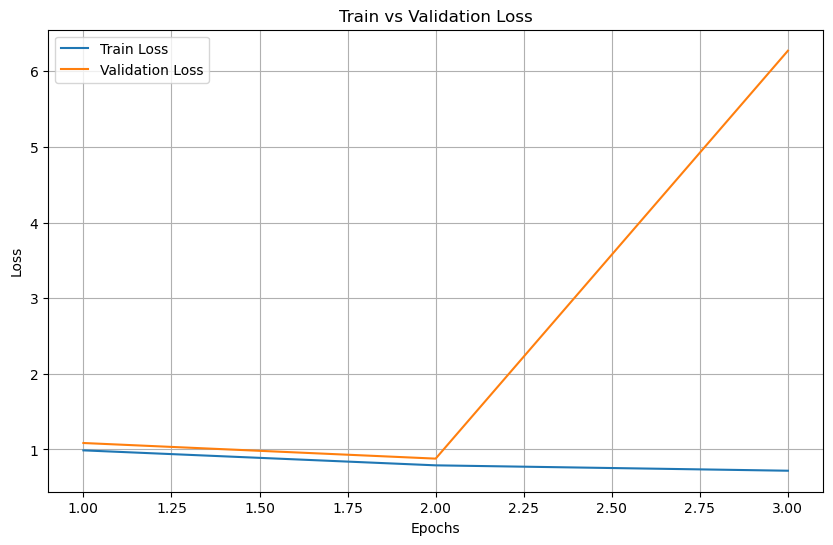

In [101]:
size = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(size, train_losses, label='Train Loss')
plt.plot(size, val_losses, label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [102]:
model_name = "U-Net.pth"
torch.save(UNet_model.state_dict(), model_name)

### UNet model predictions

In [103]:
model_path = "/kaggle/working/U-Net.pth"
UNet_model_ = UNet(num_classes=num_classes).to(device)
UNet_model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [105]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

all_test_predictions = []
all_test_labels = []

with torch.no_grad():
    for X, Y in test_data_loader:
        X, Y = X.to(device), Y.to(device)
        Y_pred = UNet_model_(X)
        Y_pred = torch.argmax(Y_pred, dim=1)
        
        all_test_predictions.append(Y_pred.cpu().numpy())  # Convert predictions to CPU and append to a list
        all_test_labels.append(Y.cpu().numpy())  # Convert ground truth labels to CPU and append to a list

# Stack all predictions and ground truth labels into numpy arrays
all_test_predictions = np.concatenate(all_test_predictions, axis=0)
all_test_labels = np.concatenate(all_test_labels, axis=0)

print("Shape of all test predictions:", all_test_predictions.shape)
print("Shape of all test labels:", all_test_labels.shape)

# Calculate and print metrics
accuracy = accuracy_score(all_test_labels.flatten(), all_test_predictions.flatten())
iou = jaccard_score(all_test_labels.flatten(), all_test_predictions.flatten(), average='weighted')
precision = precision_score(all_test_labels.flatten(), all_test_predictions.flatten(), average='weighted', zero_division=1)
recall = recall_score(all_test_labels.flatten(), all_test_predictions.flatten(), average='weighted', zero_division=1)
f1 = f1_score(all_test_labels.flatten(), all_test_predictions.flatten(), average='weighted', zero_division=1)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("IoU:", iou)

Shape of all test predictions: (348, 256, 256)
Shape of all test labels: (348, 256, 256)
Accuracy: 0.7849340767695986
Precision: 0.756153510414573
Recall: 0.7849340767695986
F1 Score: 0.7566147034970186
IoU: 0.6417744530026915


In [106]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

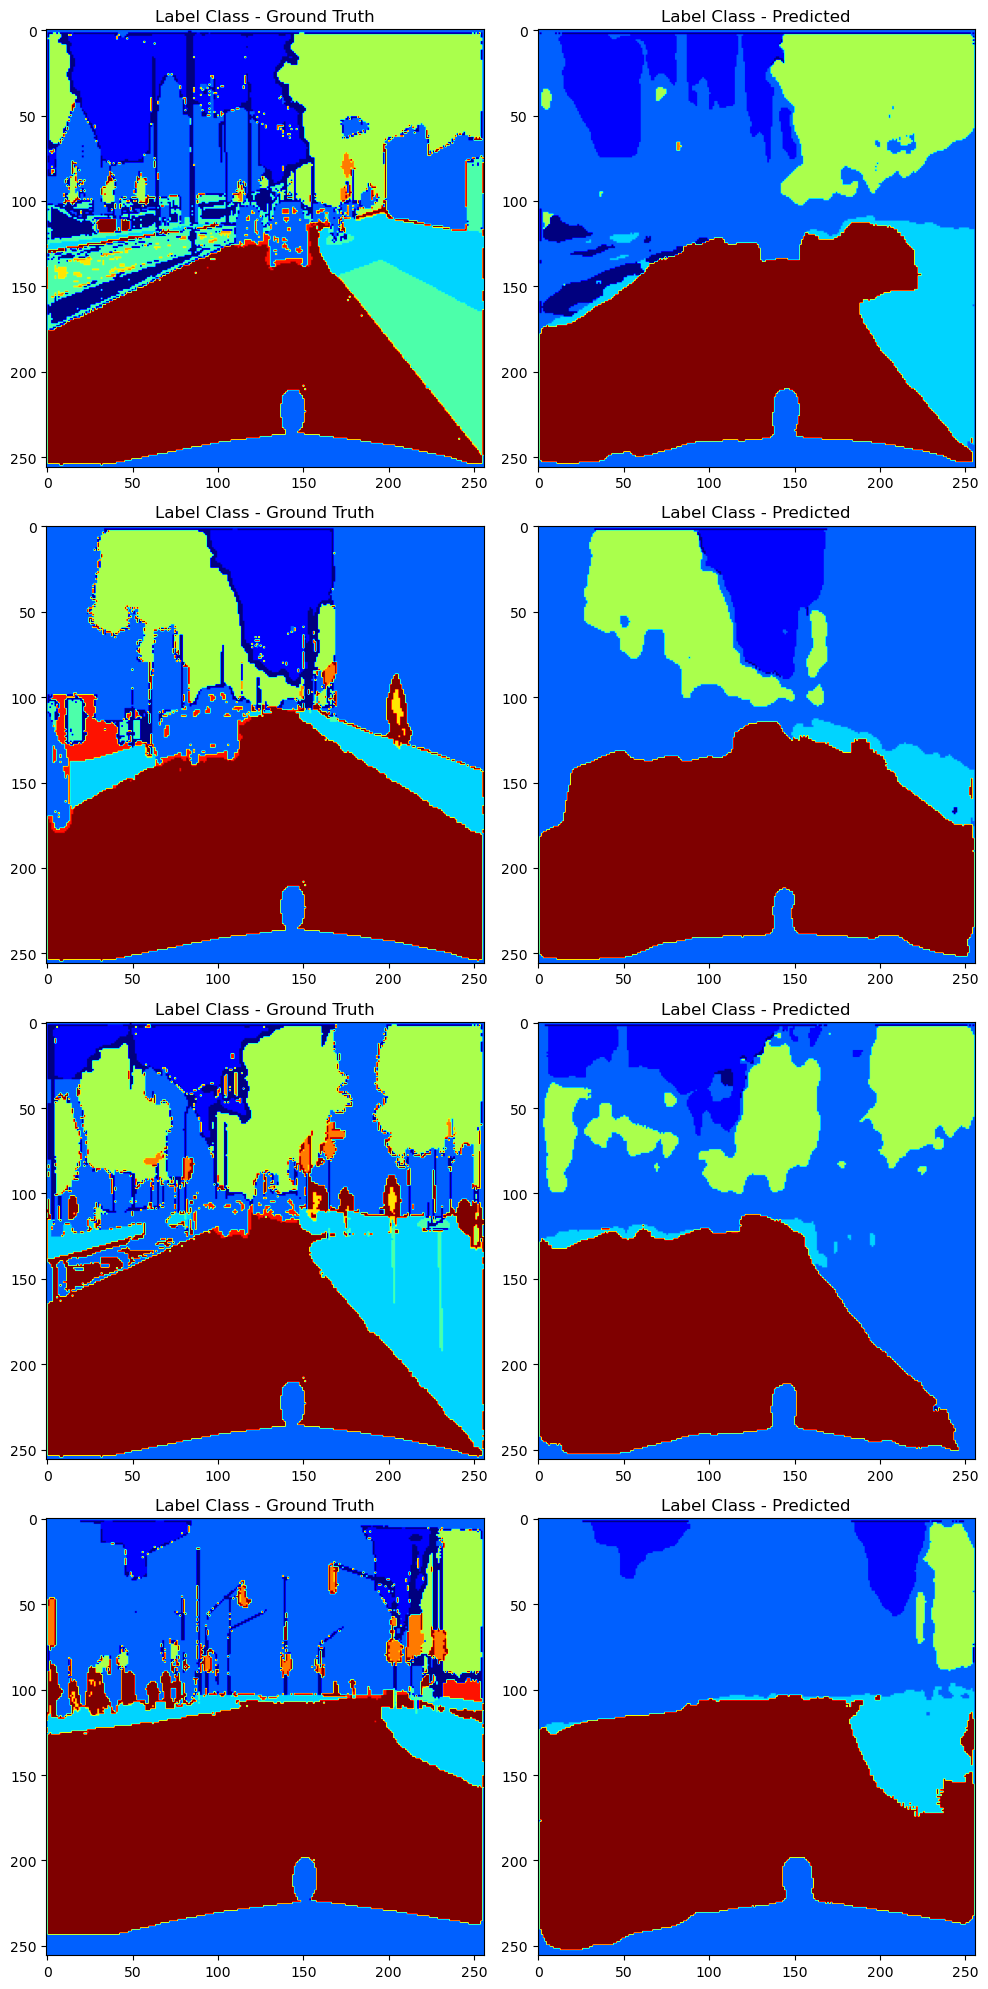

In [107]:
test_batch_size = 4
fig, axes = plt.subplots(test_batch_size, 2, figsize=(2*5, test_batch_size*5))

for i in range(test_batch_size):
    
    label_class = Y[i].cpu().numpy()
    label_class_predicted = Y_pred[i].cpu().numpy()
    
    axes[i, 0].imshow(label_class, cmap='jet', vmin=0, vmax=num_classes-1)
    axes[i, 0].set_title("Label Class - Ground Truth")
    axes[i, 1].imshow(label_class_predicted, cmap='jet', vmin=0, vmax=num_classes-1)
    axes[i, 1].set_title("Label Class - Predicted")

plt.tight_layout()
plt.show()

### 6.2 R2UNet Model

In [109]:
from tqdm import tqdm
import numpy as np
import torch

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

prev_val_loss = float('inf')  # Initialize previous validation loss to a high value
loss_increase_threshold = 0.1

for epoch in tqdm(range(epochs)):
    # Training phase
    R2UNet_model.train()
    epoch_train_loss = 0
    correct_pixels = 0
    total_pixels = 0
    
    for X, Y in train_data_loader:
        X, Y = X.to(device), Y.to(device)
        r2unet_optimizer.zero_grad()
        Y_pred = R2UNet_model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        r2unet_optimizer.step()
        epoch_train_loss += loss.item()
        
        # Convert predicted and target masks to class labels
        _, predicted_masks = torch.max(Y_pred, 1)
        
        # Calculate pixel-wise accuracy for the current batch
        correct_pixels += (predicted_masks == Y).sum().item()
        total_pixels += Y.numel()
    
    train_losses.append(epoch_train_loss / len(train_data_loader))
    
    # Validation phase
    R2UNet_model.eval()
    epoch_val_loss = 0
    
    with torch.no_grad():
        for X_val, Y_val in val_data_loader:
            X_val, Y_val = X_val.to(device), Y_val.to(device)
            Y_val_pred = R2UNet_model(X_val)
            val_loss = criterion(Y_val_pred, Y_val)
            epoch_val_loss += val_loss.item()
    
    val_losses.append(epoch_val_loss / len(val_data_loader))
    
    # Print training and validation losses for the current epoch
    print(f"Epoch {epoch+1} - Train Loss: {train_losses[epoch]:.4f} - Val Loss: {val_losses[epoch]:.4f}")
    
    # Check for validation loss increase with a threshold and stop if detected
    if epoch > 0 and val_losses[epoch] - prev_val_loss > loss_increase_threshold:
        print("Validation loss has started increasing. Stopping training.")
        break

    prev_val_loss = val_losses[epoch]

# Print training and validation losses for each epoch
for i in range(len(train_losses)):
    print(f"Epoch {i+1} - Train Loss: {train_losses[i]:.4f} - Val Loss: {val_losses[i]:.4f}")

  5%|▌         | 1/20 [04:17<1:21:35, 257.65s/it]

Epoch 1 - Train Loss: 0.9387 - Val Loss: 1.2471


 10%|█         | 2/20 [08:35<1:17:17, 257.65s/it]

Epoch 2 - Train Loss: 0.7471 - Val Loss: 1.0827


 10%|█         | 2/20 [12:52<1:55:55, 386.44s/it]

Epoch 3 - Train Loss: 0.6627 - Val Loss: 1.2809
Validation loss has started increasing. Stopping training.
Epoch 1 - Train Loss: 0.9387 - Val Loss: 1.2471
Epoch 2 - Train Loss: 0.7471 - Val Loss: 1.0827
Epoch 3 - Train Loss: 0.6627 - Val Loss: 1.2809


In [110]:
print(train_losses)
print(val_losses)

[0.9387290766952854, 0.7470910729546296, 0.6627122439738167]
[1.2471371693857785, 1.0826878314730766, 1.2809016057129563]


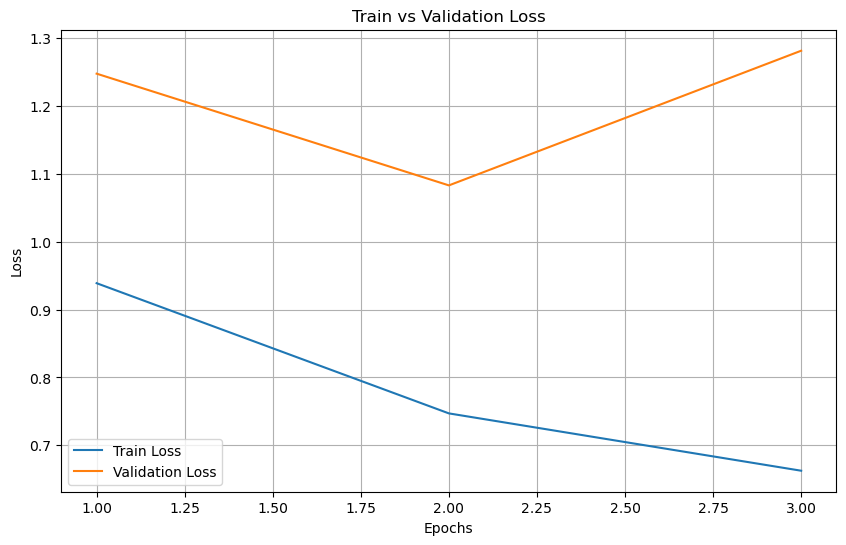

In [111]:
size = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(size, train_losses, label='Train Loss')
plt.plot(size, val_losses, label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [112]:
model_name = "R2U-Net.pth"
torch.save(R2UNet_model.state_dict(), model_name)

In [113]:
model_path = "/kaggle/working/R2U-Net.pth"
R2UNet_model_ = R2UNet().to(device)
R2UNet_model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [116]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

all_test_predictions = []
all_test_labels = []

with torch.no_grad():
    for X, Y in test_data_loader:
        X, Y = X.to(device), Y.to(device)
        Y_pred = R2UNet_model_(X)
        Y_pred = torch.argmax(Y_pred, dim=1)
        
        all_test_predictions.append(Y_pred.cpu().numpy())  # Convert predictions to CPU and append to a list
        all_test_labels.append(Y.cpu().numpy())  # Convert ground truth labels to CPU and append to a list

# Stack all predictions and ground truth labels into numpy arrays
all_test_predictions = np.concatenate(all_test_predictions, axis=0)
all_test_labels = np.concatenate(all_test_labels, axis=0)

print("Shape of all test predictions:", all_test_predictions.shape)
print("Shape of all test labels:", all_test_labels.shape)

# Calculate and print metrics
accuracy = accuracy_score(all_test_labels.flatten(), all_test_predictions.flatten())
iou = jaccard_score(all_test_labels.flatten(), all_test_predictions.flatten(), average='weighted')
precision = precision_score(all_test_labels.flatten(), all_test_predictions.flatten(), average='weighted', zero_division=1)
recall = recall_score(all_test_labels.flatten(), all_test_predictions.flatten(), average='weighted', zero_division=1)
f1 = f1_score(all_test_labels.flatten(), all_test_predictions.flatten(), average='weighted', zero_division=1)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("IoU:", iou)

Shape of all test predictions: (348, 256, 256)
Shape of all test labels: (348, 256, 256)
Accuracy: 0.8108546816069504
Precision: 0.7852635174555757
Recall: 0.8108546816069504
F1 Score: 0.7854022941104025
IoU: 0.6797314025217414


In [117]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

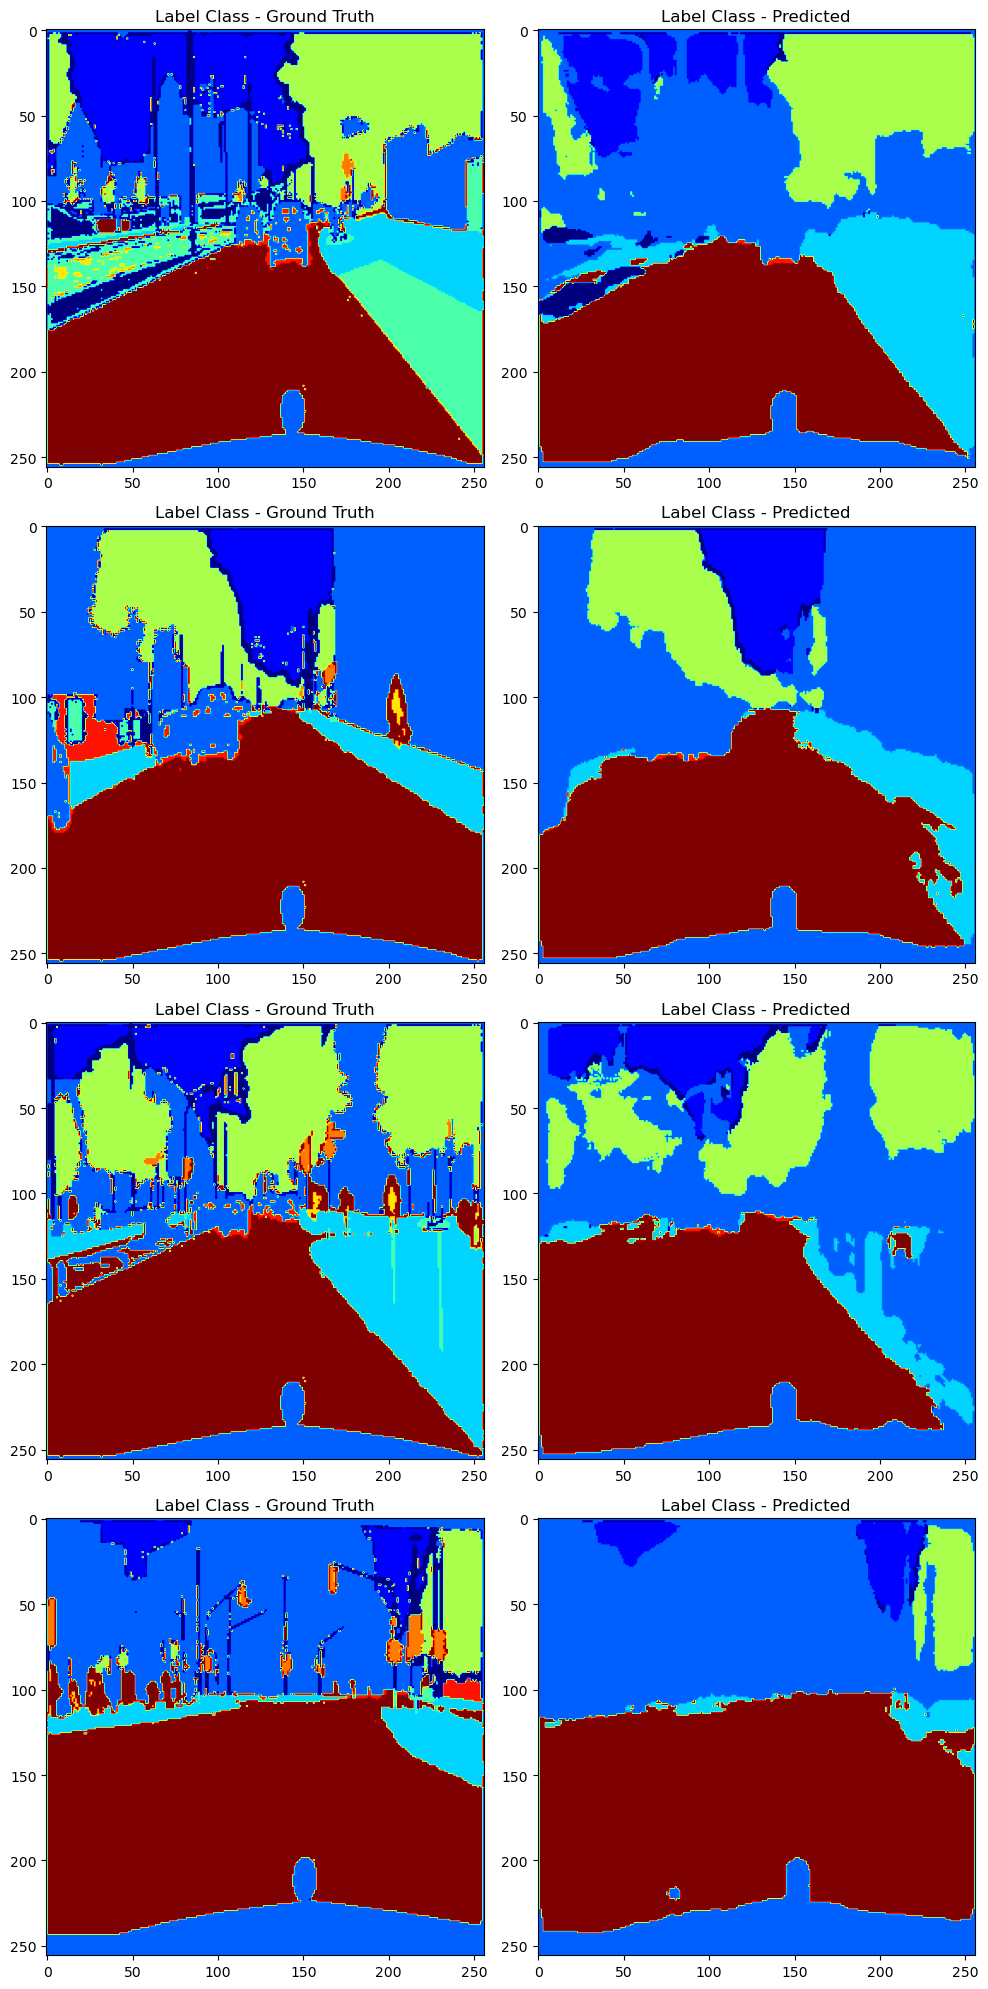

In [118]:
test_batch_size = 4
fig, axes = plt.subplots(test_batch_size, 2, figsize=(2*5, test_batch_size*5))

for i in range(test_batch_size):
    
    label_class = Y[i].cpu().numpy()
    label_class_predicted = Y_pred[i].cpu().numpy()
    
    axes[i, 0].imshow(label_class, cmap='jet', vmin=0, vmax=num_classes-1)
    axes[i, 0].set_title("Label Class - Ground Truth")
    axes[i, 1].imshow(label_class_predicted, cmap='jet', vmin=0, vmax=num_classes-1)
    axes[i, 1].set_title("Label Class - Predicted")

plt.tight_layout()
plt.show()